In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.circuit.library import ZGate, XGate
from qiskit import execute, Aer
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import gc
import csv
from pylab import *

In [2]:
def createSFblock(N, j):
    
    circuit = QuantumCircuit(N)
    
    state_decimal = format(j, '0'+str(N)+'b')[::-1] # inverse order due to Qiskit order: |q1q0>
    
    for qubit in range(N):
        if state_decimal[qubit] == '0':
            circuit.x(qubit)
    
    multiConrolledZ = ZGate().control(num_ctrl_qubits=N-1)
    circuit.append(multiConrolledZ, range(N))
    
    for qubit in range(N):
        if state_decimal[qubit] == '0':
            circuit.x(qubit)
    
    return circuit


In [3]:
def U_i(N, ki, circuit):
    
    # create equal superposition
    circuit.h(range(N))
    
    # apply SF blocks according to ki information
    vector_i = format(ki, '0'+str(2**N)+'b')
    for ij in range(len(vector_i)):
        if vector_i[ij] == '1': # n_j = 1, equivalent of having -1 in vector i
            circuit.compose(createSFblock(N, ij), inplace=True)  # the state i is the one that must have the phase of -1

def U_w(N, kw, circuit):
    
    # apply SF blocks according to kw information
    vector_w = format(kw, '0'+str(2**N)+'b')
    for wj in range(len(vector_w)):
        if vector_w[wj] == '1': # n_j = 1, equivalent of having -1 in vector w
            circuit.compose(createSFblock(N, wj), inplace=True)  # the state w is the one that must have the phase of -1
    
    # apply Hadamards
    circuit.h(range(N))
    
    # apply NOTs
    circuit.x(range(N))

In [4]:
def perceptron_brute_force(N, ki, kw, draw=False):
    
    # create circuit, N qubits + ancilla
    circuit = QuantumCircuit(N + 1, 1)
    
    # apply U_i
    U_i(N, ki, circuit)
    
    # apply U_w
    U_w(N, kw, circuit)
    
    # apply C^N X
    circuit.mcx(control_qubits=[i for i in range(N)], target_qubit=N)
    
    # measure the ancilla qubit
    circuit.measure(N, 0)
    
    # draw circuit
    if draw == True:
        display(circuit.draw('mpl'))
    
    return circuit

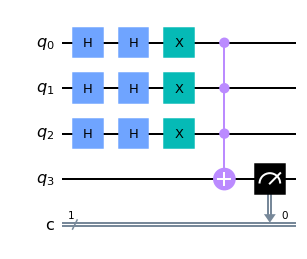

In [6]:
perceptron_brute_force(N=3, ki=0, kw=0, draw=True)

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
#QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True)

In [8]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [9]:
service.backends()

[<IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>]

In [10]:
backend = service.backends(simulator=True)[0]
print(backend)

<IBMBackend('ibmq_qasm_simulator')>


In [11]:
backend_belem = service.backends(name='ibmq_belem')[0]
backend_belem

<IBMBackend('ibmq_belem')>

In [12]:
from qiskit.providers.fake_provider import FakeBelemV2
from qiskit_aer.noise import NoiseModel

# Import FakeBackend
fake_backend = FakeBelemV2()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include noise_model
options = Options(simulator={
    "noise_model": noise_model
}, resilience_level=0)

/opt/conda/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:145: UserWarning: When `target` is supplied, `standard_gates` and `warnings` are ignored, and they are always set to true.
  warn("When `target` is supplied, `standard_gates` and `warnings` are ignored,"


In [ ]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc1,qc2])
    result = job.result()
    print(job.job_id())

In [13]:
%%time

# Calculate for every value for ki and kw

N = 3

jobs_executed = {}

for kw in range(2**(2**N)):
#for kw in range(184,2**(2**N)):
    
    print("\rworking with kw = {}/{}".format(kw, 2**(2**N)), end="")
    
    circuits_sim = []
    
    for ki in range(2**(2**N)):
        perceptron_circuit = perceptron_brute_force(N, ki, kw)
        circuits_sim.append(transpile(perceptron_circuit, backend_belem))
    
    with Session(service=service, backend=backend):
        sampler = Sampler(options=options)
        job = sampler.run(circuits=circuits_sim)
        result = job.result()
        
    jobs_executed[kw] = job.job_id()
    
    with open("res_simple/results_fake_belem_straightforward_Ui_Uw_N3_kw_{}.txt".format(kw), "w") as file:
        file.write(str(result.quasi_dists))
    
    del circuits_sim
    del sampler
    del job
    del result
    gc.collect()
    

with open("res_simple/results_fake_belem_straightforward_Ui_Uw_N3_jobs.txt", "w") as file:
    file.write(str(jobs_executed))

working with kw = 255/256CPU times: user 2h 1min 26s, sys: 47.9 s, total: 2h 2min 14s
Wall time: 4h 58min 10s


In [2]:
%%time
# load results from generated files and save them in matrix form in a new file

N = 3

with open("res_simple/results_fake_belem_straightforward_Ui_Uw_N3_all.txt", "w", newline="") as f:
    
    writer = csv.writer(f, delimiter=' ')
    
    for kw in range(2**(2**N)):

        print("\rreading for kw = {}/{}".format(kw, 2**(2**N)), end="")

        with open("res_simple/results_fake_belem_straightforward_Ui_Uw_N3_kw_{}.txt".format(kw), "r") as file:
            results_for_kw = eval(file.readline())

        results_for_state1 = []
        for ki in range(2**(2**N)):
            results_for_state1.append(results_for_kw[ki][1])
        
        writer.writerow(results_for_state1)

        del results_for_kw
        del results_for_state1
        gc.collect()
    

reading for kw = 255/256CPU times: total: 17.4 s
Wall time: 17.5 s


In [6]:
%%time

# calculate average discrepancy

N = 3

D = 0

for kw in range(2**(2**N)):
    
    print("\rcalculating for kw = {}/{}".format(kw, 2**(2**N)), end="")

    with open("res_simple/results_fake_belem_straightforward_Ui_Uw_N3_kw_{}.txt".format(kw), "r") as file:
        results_for_kw_simple = eval(file.readline())
    
    results_for_state1_simple = []
    for ki in range(2**(2**N)):
        results_for_state1_simple.append(results_for_kw_simple[ki][1])
    
    with open("res_exact/results_fake_belem_exact_Ui_Uw_N3_kw_{}.txt".format(kw), "r") as file:
        results_for_kw_exact = eval(file.readline())
    
    results_for_state1_exact = []
    for ki in range(2**(2**N)):
        results_for_state1_exact.append(results_for_kw_exact[ki][1])
    
    D += np.sum(np.absolute(np.subtract(results_for_state1_simple, results_for_state1_exact))) / (2**(2**(N+1)))
    
print()

D

calculating for kw = 255/256
CPU times: total: 1.97 s
Wall time: 2.33 s


0.1382365112304688